In [1]:
import multiprocessing
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def XGBRegressorForSurvey (df, emotion, testRatio = 0.2):
    """predict whether the surveyee will be craving given the survey
    
    Args: 
        df (pd.DataFrame): the data set we need for the training and test data
        emotion (str): the emotion we are interested in
        testRatio (float) : ratio of the test data in the whole dataset
    
    """    
    
    # get the name of columns for features
    new_cols = [col for col in df.columns if col != emotion] + [emotion]
    df = df[new_cols]
    feature_columns = new_cols[:-1]

    # Isolate the x and y variables
    y = df.iloc[:, -1].values
    X = df.iloc[:, :-1].values
    
    #split dataset into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testRatio)
    
    # Create xgboost matrices
    Train = xgb.DMatrix(X_train, label = y_train, feature_names = feature_columns)
    Test = xgb.DMatrix(X_test, label = y_test, feature_names = feature_columns)
    
    # Tuning parameters: Round 1
    print("=====Parameter Tunning Round 1=====")
    
    tune_control = KFold(n_splits = 5, shuffle = True).split(X = X_train, y = y_train)
    tune_grid = {'learning_rate': [0.05, 0.3],
                 'max_depth': range(2, 9, 2),
                 'colsample_bytree': [0.5, 1],
                 'subsample': [1],
                 'gamma': [0], 
                 'n_estimators': range(200, 2000, 200),
                 'booster': ["gbtree"]}
    
    regressor = XGBRegressor(objective = "reg:squarederror")
    
    # Cross Validation Assembly
    nJobs = multiprocessing.cpu_count() - 2
    grid_search = GridSearchCV(estimator = regressor,
                               param_grid = tune_grid,
                               scoring = "neg_root_mean_squared_error",
                               n_jobs = nJobs,
                               cv = 5,
                               verbose = 4)


    # Hyperparameter tuning and cross validation
    tune_model = grid_search.fit(X = X_train, y = y_train)
    grid_search.best_params_, grid_search.best_score_
    
    
    # Tuning parameters: Round 2
    print("=====Parameter Tunning Round 2=====")
    
    tune_control = KFold(n_splits = 5, shuffle = True).split(X = X_train, y = y_train)
    tune_grid2 = {'learning_rate': [grid_search.best_params_.get('learning_rate')],
                   'max_depth': [grid_search.best_params_.get('max_depth')],
                   'colsample_bytree': [grid_search.best_params_.get('colsample_bytree')],
                   'subsample': [0.9, 1],
                   'gamma': [0, 0.1], 
                   'n_estimators': range(200, 2000, 200),
                   'booster': ["gbtree"]}                                                

    #Cross Validation Assembly
    grid_search2 = GridSearchCV(estimator = regressor,
                               param_grid = tune_grid2,
                                scoring = "neg_root_mean_squared_error",
                                n_jobs = nJobs,
                                cv = tune_control,
                                verbose = 5)

    # Hyperparameter tuning and cross validation
    tune_model2 = grid_search2.fit(X = X_train, y = y_train)
    grid_search2.best_params_, grid_search2.best_score_
    
    # We can continue tunning the hyperparameters...
    grid_search_last = grid_search2
    
    # Final model
    print("=====Final Model=====")
    finalParameters = {'learning_rate': grid_search_last.best_params_.get('learning_rate'),
                       'max_depth': grid_search_last.best_params_.get('max_depth'),
                       'colsample_bytree': grid_search_last.best_params_.get('colsample_bytree'),
                       'subsample': grid_search_last.best_params_.get('subsample'),
                       'gamma': grid_search_last.best_params_.get('gamma'), 
                       'eval_metric': "rmse",
                       'objective': "reg:squarederror"}
    
    finalModel = xgb.train(params = finalParameters,
                   dtrain = Train,
                   num_boost_round = 800,
                   evals = [(Test, "Yes")],
                   verbose_eval = 50)
    
    # Predictions on test dataset
    predictions = finalModel.predict(Test)
    
    # Model Diagnostic
    print("=====Model Diagnostic=====")
    
    # find rmse
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print("RMSE: %f" % (rmse))
    
    # plot feature importances
    xgb.plot_importance(finalModel, max_num_features = 10)
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.show()
    

In [2]:
df = pd.read_csv('agg_data.csv')
df = df.drop(['ts', '_window_end'], axis=1)
df.head()

,acc_x,acc_y,acc_z,bvp,conductance,heartrate,temperature,stressed,acc_x_1h__mean,acc_x_1h__std,...,acc_z_1h__mean,acc_z_1h__std,bvp_1h__mean,bvp_1h__std,conductance_1h__mean,conductance_1h__std,heartrate_1h__mean,heartrate_1h__std,temperature_1h__mean,temperature_1h__std
0,59.0,21.0,-21.0,-463.175,0.039721,109.23,34.75,3.0,44.143213,19.002027,...,-14.214931,25.811113,0.061996,188.057266,0.511844,0.735550,87.472742,13.624653,34.490249,0.665562
1,-57.0,21.0,-18.0,-169.770,0.683216,93.65,32.33,3.0,-17.675239,45.658263,...,7.577908,31.696079,-0.013041,175.206632,0.712755,1.313117,90.409003,14.367658,32.513215,1.158329
2,-53.0,18.0,31.0,91.250,0.088412,128.02,32.05,3.0,-17.675239,45.658263,...,7.577908,31.696079,-0.013041,175.206632,0.712755,1.313117,90.409003,14.367658,32.513215,1.158329
3,-23.0,59.0,18.0,113.700,0.151197,85.67,31.91,7.0,-17.675239,45.658263,...,7.577908,31.696079,-0.013041,175.206632,0.712755,1.313117,90.409003,14.367658,32.513215,1.158329
4,-57.0,-17.0,26.0,88.600,0.165292,69.27,31.17,7.0,-17.675239,45.658263,...,7.577908,31.696079,-0.013041,175.206632,0.712755,1.313117,90.409003,14.367658,32.513215,1.158329


=====Parameter Tunning Round 1=====
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   14.5s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 209 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 380 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 601 tasks      | elapsed: 614.8min
[Parallel(n_jobs=6)]: Done 720 out of 720 | elapsed: 623.8min finished


=====Parameter Tunning Round 2=====
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    6.2s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed: 15.2min
[Parallel(n_jobs=6)]: Done 180 out of 180 | elapsed: 21.6min finished


=====Final Model=====
[0]	Yes-rmse:5.03739
[50]	Yes-rmse:1.70109
[100]	Yes-rmse:1.39251
[150]	Yes-rmse:1.22307
[200]	Yes-rmse:1.11237
[250]	Yes-rmse:1.02825
[300]	Yes-rmse:0.97592
[350]	Yes-rmse:0.93060
[400]	Yes-rmse:0.89354
[450]	Yes-rmse:0.86684
[500]	Yes-rmse:0.84381
[550]	Yes-rmse:0.82913
[600]	Yes-rmse:0.81694
[650]	Yes-rmse:0.81110
[700]	Yes-rmse:0.80635
[750]	Yes-rmse:0.80339
[799]	Yes-rmse:0.79790
=====Model Diagnostic=====
RMSE: 0.797902


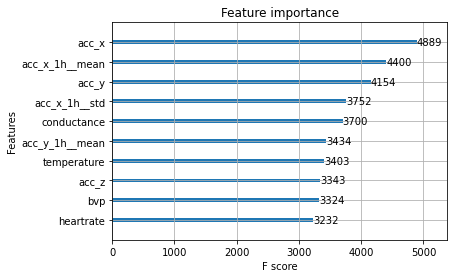

In [3]:
XGBRegressorForSurvey(df, "stressed" ,testRatio = 0.2)